In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [129]:
df = pd.read_csv('data/cleaned_all_transactions.csv').iloc[:, 1:]

## **Hypothesis Testing**

What's our question?

As we saw in the cleaning/eda section of the report, the state of Michigan has a 77% of trades that result in the ```cap_gains_over_200_usd``` column have a True value. 

Is this just by chance, or are the representatives from the *The Great Lakes State* just that damn good?

In [130]:
df = df[['state', 'cap_gains_over_200_usd']]
df.head(5)

,state,cap_gains_over_200_usd
0,NC,False
1,NC,False
2,NC,False
3,NC,False
4,CA,False


Let's look at the data once again.

In [131]:
df.groupby('state').mean().sort_values(by='cap_gains_over_200_usd', ascending=False).head(5)

,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222


##### There's an easy solution to this problem - **Permutation Testing!**

We're choosing permutation testing over hypothesis testing because we are given *two* observed samples (versus the only *one* that hypothesis testing works on), and we need to see if they are they fundamentally different, or could they have been generated by the same process? 


In [132]:
df.sample(frac=1).head(3)

,state,cap_gains_over_200_usd
4596,TN,False
1495,NY,True
7424,CT,False


We can shuffle the ```cap_gains_over_200_usd``` column to simulate randomness.

In [133]:
shuffled_gains = (
    df['cap_gains_over_200_usd']
    .sample(frac=1)
    # we need to reset_index w/ drop=True otherwise the old index values will exist
    .reset_index(drop=True)
)
shuffled_gains.head(3)

0    False
1    False
2    False
Name: cap_gains_over_200_usd, dtype: bool

In [134]:
og_and_shuffled = (
    df.assign(**{'shuffled_cap_gains_over_200_usd': shuffled_gains})
)
og_and_shuffled.head(3)

,state,cap_gains_over_200_usd,shuffled_cap_gains_over_200_usd
0,NC,False,False
1,NC,False,False
2,NC,False,False


Now that we've done the shuffling, let's recreate the pivot table we saw before, but this time with the added ```shuffled_cap_gains_over_200_usd``` column.

In [135]:
table = (
    og_and_shuffled.pivot_table(index = 'state')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
)
table.loc[['MI']]

,cap_gains_over_200_usd,shuffled_cap_gains_over_200_usd
state,,
MI,0.772871,0.066246


In [136]:
table

,cap_gains_over_200_usd,shuffled_cap_gains_over_200_usd
state,,
MI,0.772871,0.066246
SC,0.379310,0.034483
NY,0.280702,0.061404
ID,0.222222,0.037037
LA,0.222222,0.000000
KY,0.115942,0.057971
AR,0.111111,0.111111
WI,0.105263,0.052632
GA,0.103004,0.051502


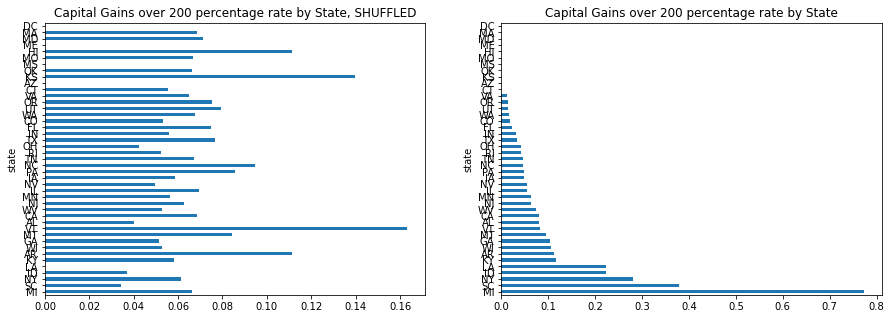

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

title = 'Capital Gains over 200 percentage rate by State, SHUFFLED'
table['shuffled_cap_gains_over_200_usd'].plot(kind='barh', title=title, ax=axes[0]);

title = 'Capital Gains over 200 percentage rate by State'
table['cap_gains_over_200_usd'].plot(kind='barh', title=title, ax=axes[1]);

In [66]:
og_and_shuffled.groupby('state').mean().sort_values(by='cap_gains_over_200_usd', ascending=False).loc['MI']

cap_gains_over_200_usd             0.772871
shuffled_cap_gains_over_200_usd    0.072555
Name: MI, dtype: float64